Analyses properties of decorrelation and whitening methods for decorrelated networks

In [1]:
import numpy as np
import torch
import torch.nn as nn
from decorrelation.decorrelation import Decorrelation, DecorLinear, DecorConv2d
import matplotlib.pyplot as plt
import matplotlib
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from decorrelation.training import decor_train
import argparse
from decorrelation.plotting import *

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5), (0.5)),
        # torch.flatten # not necessary but useful for debugging
        ])

train_data = MNIST(root='~/Data', train=True, download=True, transform=transform)
train_data = Subset(train_data, np.random.permutation(len(train_data.data))[:1000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [3]:
args = argparse.Namespace(lr=0.0, kappa=1e-2, decor_lr=1e0, epochs=10)

model = Decorrelation(784, bias=False, kappa=args.kappa).to(device)

lossfun = lambda x, y: nn.Parameter(torch.zeros(1, device=device, dtype=float), requires_grad=True)

res = decor_train(args, model, lossfun, train_loader, device)

epoch 0  	time:0.000 s	bp loss: 0.000000	decorrelation loss: 6.627906
epoch 1  	time:0.319 s	bp loss: 0.000000	decorrelation loss: 6.338502
epoch 2  	time:0.344 s	bp loss: 0.000000	decorrelation loss: 5.772131
epoch 3  	time:0.333 s	bp loss: 0.000000	decorrelation loss: 5.262663
epoch 4  	time:0.332 s	bp loss: 0.000000	decorrelation loss: 4.841757
epoch 5  	time:0.327 s	bp loss: 0.000000	decorrelation loss: 4.469853
epoch 6  	time:0.327 s	bp loss: 0.000000	decorrelation loss: 4.121214
epoch 7  	time:0.324 s	bp loss: 0.000000	decorrelation loss: 3.824177
epoch 8  	time:0.316 s	bp loss: 0.000000	decorrelation loss: 3.550914
epoch 9  	time:0.315 s	bp loss: 0.000000	decorrelation loss: 3.314016
epoch 10 	time:0.341 s	bp loss: 0.000000	decorrelation loss: 3.112059


layer 1:

mean covariance before decorrelation: 0.54
mean variance before decorrelation: 0.92

mean covariance after decorrelation: 0.35
mean variance after decorrelation: 0.71



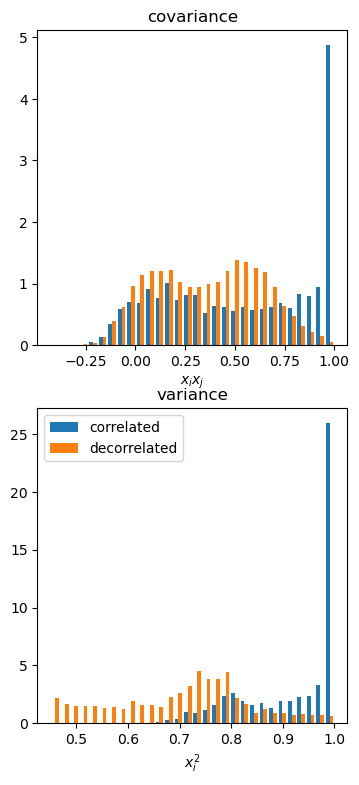

In [4]:
init_model = Decorrelation(784, bias=False, kappa=args.kappa).to(device)
plot_correlations(init_model, model, train_loader, device)

In [5]:
args = argparse.Namespace(lr=1e-4, kappa=1e-2, decor_lr=1e0, epochs=10)

class Model(nn.Sequential):
    def __init__(self, in_features, kappa):
        super().__init__(DecorLinear(in_features, 100, kappa=kappa))

    def forward(self, x):
        return super().forward(x.view(len(x), -1))
    
model = Model(784, kappa=args.kappa).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = decor_train(args, model, lossfun, train_loader, device)

epoch 0  	time:0.000 s	bp loss: 5.000473	decorrelation loss: 6.632717
epoch 1  	time:0.315 s	bp loss: 4.290308	decorrelation loss: 6.319735
epoch 2  	time:0.311 s	bp loss: 3.172367	decorrelation loss: 5.775041
epoch 3  	time:0.321 s	bp loss: 2.611036	decorrelation loss: 5.284281
epoch 4  	time:0.313 s	bp loss: 2.345288	decorrelation loss: 4.838430
epoch 5  	time:0.312 s	bp loss: 2.180123	decorrelation loss: 4.450455
epoch 6  	time:0.310 s	bp loss: 2.062571	decorrelation loss: 4.112192
epoch 7  	time:0.308 s	bp loss: 1.960825	decorrelation loss: 3.822798
epoch 8  	time:0.310 s	bp loss: 1.877483	decorrelation loss: 3.575881
epoch 9  	time:0.323 s	bp loss: 1.794352	decorrelation loss: 3.329617
epoch 10 	time:0.309 s	bp loss: 1.719295	decorrelation loss: 3.115582


layer 1:

mean covariance before decorrelation: 0.55
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.36
mean variance after decorrelation: 0.71



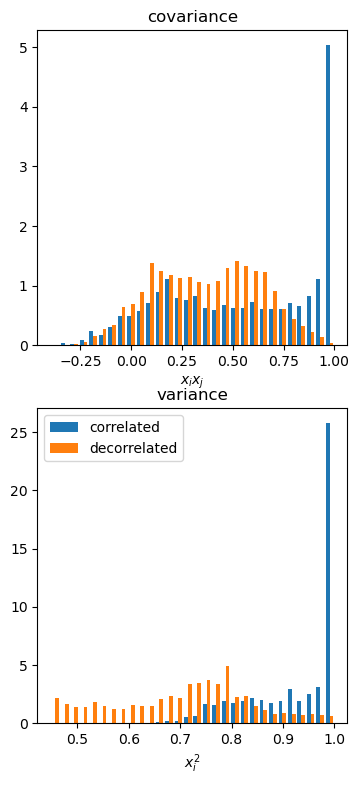

In [6]:
init_model = Model(784, kappa=args.kappa).to(device)
plot_correlations(init_model, model, train_loader, device)

In [9]:
args = argparse.Namespace(lr=1e-3, kappa=1e-2, decor_lr=1e1, epochs=30)

class Model(nn.Sequential):
    def __init__(self, in_features, kappa):
        super().__init__(DecorLinear(in_features, 100, decor_bias=False, kappa=kappa),
                        nn.LeakyReLU(),
                        DecorLinear(100, 10, decor_bias=False, kappa=kappa)
                        )

    def forward(self, x):
        return super().forward(x.view(len(x), -1))

# class Model(nn.Sequential):
#     def __init__(self, in_features, eta, whiten):
#         super().__init__(Decorrelation(in_features, bias=False, eta=eta, whiten=whiten),
#                         nn.BatchNorm1d(in_features),
#                         nn.Linear(in_features, 100),
#                         nn.LeakyReLU(),
#                         Decorrelation(100, bias=False, eta=eta, whiten=whiten),
#                         nn.BatchNorm1d(100),
#                         nn.Linear(100, 10)
#                         )
    
model = Model(784, kappa=args.kappa).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = decor_train(args, model, lossfun, train_loader, device)

epoch 0  	time:0.000 s	bp loss: 2.465408	decorrelation loss: 7.015496
epoch 1  	time:0.326 s	bp loss: 1.966616	decorrelation loss: 6.355591
epoch 2  	time:0.335 s	bp loss: 1.190361	decorrelation loss: 3.793717
epoch 3  	time:0.335 s	bp loss: 0.876706	decorrelation loss: 2.591321
epoch 4  	time:0.332 s	bp loss: 0.753370	decorrelation loss: 1.840187
epoch 5  	time:0.327 s	bp loss: 0.665711	decorrelation loss: 1.402852
epoch 6  	time:0.324 s	bp loss: 0.586505	decorrelation loss: 1.710213
epoch 7  	time:0.323 s	bp loss: 0.539393	decorrelation loss: 1.260344
epoch 8  	time:0.325 s	bp loss: 0.501876	decorrelation loss: 1.041702
epoch 9  	time:0.302 s	bp loss: 0.465254	decorrelation loss: 0.941192
epoch 10 	time:0.303 s	bp loss: 0.419989	decorrelation loss: 1.012646
epoch 11 	time:0.304 s	bp loss: 0.390032	decorrelation loss: 1.017684
epoch 12 	time:0.303 s	bp loss: 0.362456	decorrelation loss: 0.833051
epoch 13 	time:0.308 s	bp loss: 0.330615	decorrelation loss: 0.831153
epoch 14 	time:0.321

layer 1:

mean covariance before decorrelation: 0.54
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.02
mean variance after decorrelation: 0.31

layer 2:

mean covariance before decorrelation: 0.06
mean variance before decorrelation: 0.17

mean covariance after decorrelation: 0.00
mean variance after decorrelation: 0.53



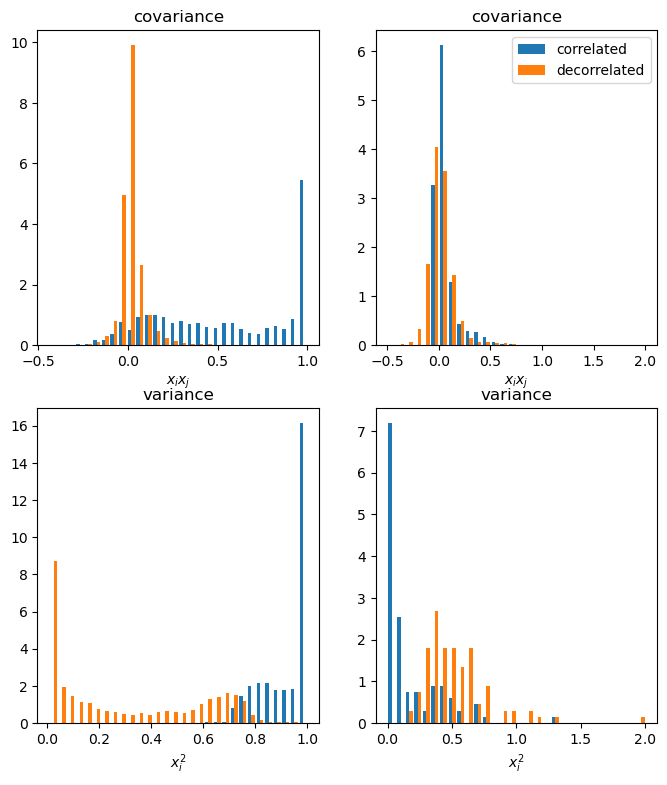

In [10]:
init_model = Model(784, kappa=args.kappa).to(device)
plot_correlations(init_model, model, train_loader, device)